In [438]:
import h5py
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner
import numpy.ma as ma

In [555]:
avg = h5py.File('/home/saurabhs/Documents/amarnath/hdatasets/2025-04-13_053004.pyavg','r')
med = h5py.File('/home/saurabhs/Documents/amarnath/hdatasets/2025-04-13_053004.pymed','r')

In [440]:
print(list(avg.keys()))
print(list(med.keys()))

['SPCD', 'SPCF', 'mask', 'params', 'pyavg']
['11', '12', '22', 'lst', 'mask', 'params', 'pymedian', 'pytag', 'time']


In [675]:
#Frequencies
avg['pyavg'].keys()
sfreq = avg.attrs['sfreq']
print(avg.attrs.keys())
freq=np.arange(0,8193,1)*sfreq*1e3
#print(freq)
freq = freq[1::2]
ind_freq=np.logical_and((freq>=40),(freq<=110))
print(freq[ind_freq])
req_freq=freq[ind_freq]*1e6
print(req_freq.shape)

<KeysViewHDF5 ['sfreq']>
[ 40.00854492  40.06958008  40.13061523 ... 109.83276367 109.89379883
 109.95483398]
(1147,)


### Averaged Data

In [729]:
SPCD_avg=avg['SPCD'][:, 1::2]
SPCF_avg=avg['SPCF'][:, 1::2]
mask_avg=avg['mask'][:, 1::2].real
print(SPCF_avg.shape)
SPCD_avg=SPCD_avg[0, ind_freq]
SPCF_avg=SPCF_avg[0,ind_freq]
mask_avg=mask_avg[0, ind_freq].real
print(SPCF_avg.real)

(1, 4096)
[0.02344228 0.02358741 0.02390716 ... 0.02614549 0.02550877 0.02584896]


(1147,)


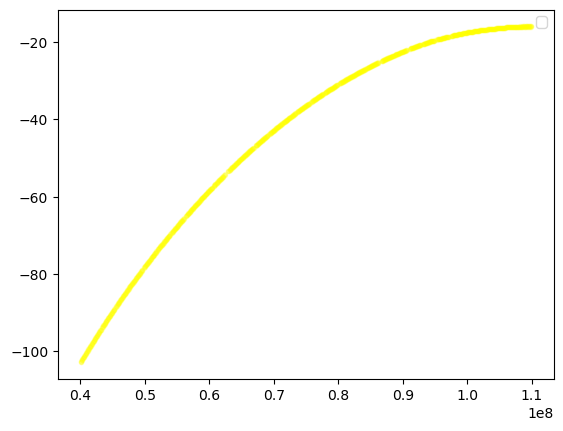

[1. 1. 1. ... 1. 1. 1.]
(1066,)


In [682]:
#plotting the averaged data
print(req_freq.shape)
#plt.scatter(req_freq[mask_avg==0], SPCD_avg.real[mask_avg==0], marker='.', color='red', alpha = 0.7)
plt.scatter(req_freq[mask_avg==1], SPCD_avg.real[mask_avg==1], marker='.', color='yellow', alpha = 0.2)
plt.legend()
#plt.xlim(0.6e8, 0.7e8)
plt.show()
print(mask_avg.real)
print(SPCD_avg.real[mask_avg==1].shape)

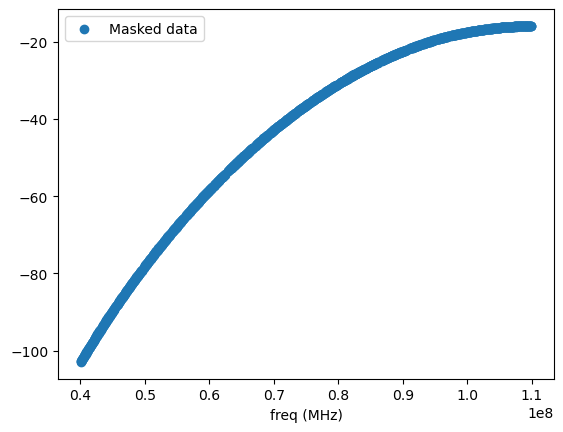

In [684]:
TMeas_exp_avg=ma.masked_array(SPCD_avg,np.logical_not(mask_avg))  ##Masking
plt.scatter(req_freq,TMeas_exp_avg.real, label='Masked data')
#plt.plot(req_freq,SPCD_avg[0][ind_freq].real, alpha=0.8, label=('Data'))
#plt.xlim(0.9e8, 0.91e8)
plt.xlabel('freq (MHz)')
plt.legend()
plt.show()

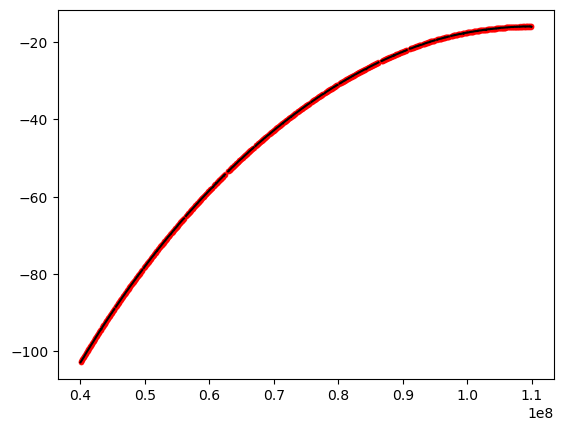

In [686]:
plt.plot(req_freq,TMeas_exp_avg.real, 'k', label='Masked data')
plt.scatter(req_freq[mask_avg==1], SPCD_avg.real[mask_avg==1], marker='.', color='red', alpha = 0.7)
#plt.scatter(req_freq[mask_avg==1], SPCD_avg.real[mask_avg==1], marker='.', color='yellow', alpha = 0.2)

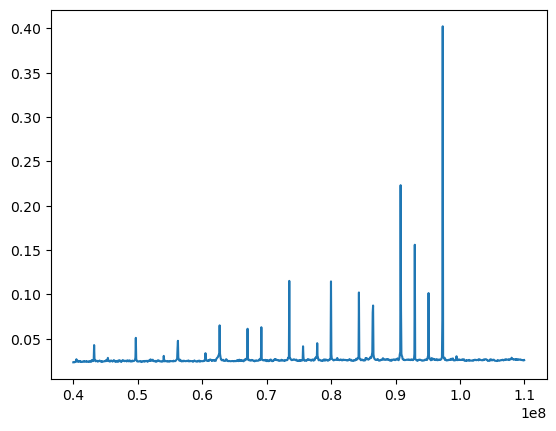

In [687]:
#plotting uncertainities ----> SPCF
plt.plot(req_freq,SPCF_avg.real)
plt.show()

### Data Median

In [466]:
corr=med['11']
list(corr.keys())

['SPCD', 'SPCF']

In [467]:
SPCD_med=corr['SPCD']
SPCF_med=corr['SPCF']
mask_med=med['mask']
lst_med=med['lst']
time_med=med['time']

In [534]:
print(SPCD_med.shape)
print(SPCF_med.shape)
print(mask_med.shape)


(3471, 8193)
(0, 8193)
(3471, 8193)


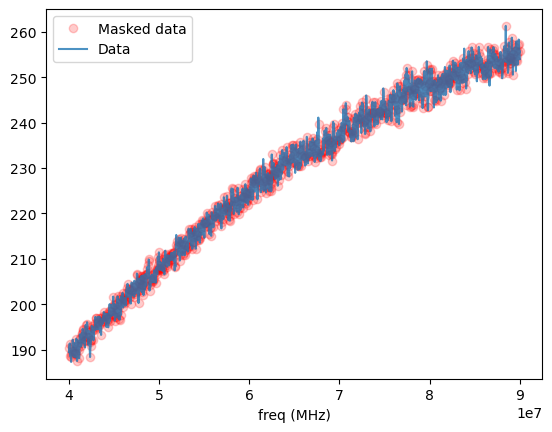

In [553]:
## Plotting masked median data
TMeas_exp=ma.masked_array(SPCD_med[0],mask_med[0])  ##Masking

plt.plot(req_freq,TMeas_exp.real[ind_freq],'ro', label='Masked data', alpha=0.2)
plt.plot(req_freq,SPCD_med[0][ind_freq].real, alpha=0.8, label=('Data'))

plt.xlabel('freq (MHz)')
plt.legend()
plt.show()

In [198]:
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_Model/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_Model/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, 
Phase (in degrees)]
c=3*10**8  # speed of light (m/s)
freq_data=[d[i][0] for i in range(len(d)-1)] #frequency

In [568]:
def Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    global req_freq #[d[i][0] for i in range(len(d))]
    for i in range(len(req_freq)):
        gamma_A=p0*1e-48*req_freq[i]**(N - 1) + p1*1e-39*req_freq[i]**(N - 2) + p2*1e-31*req_freq[i]**(N - 3) + p3*1e-23*req_freq[i]**(N - 4) + p4*1e-15*req_freq[i]**(N - 5) + p5*1e-08*req_freq[i]**(N - 6) + p6*1e-01
        
        phi= (4*math.pi*(req_freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*(1-(gamma_A**2))*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return Tmeas

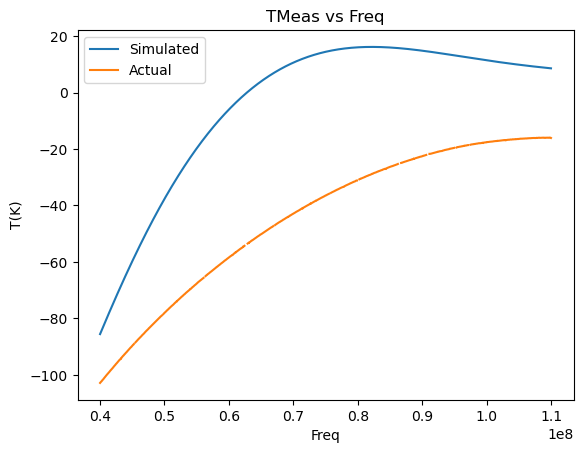

In [689]:
T=Compute_Tmeas_(300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07, 4.73, 70, 0.3, 0.1, 0.15)

plt.plot(req_freq,T, label="Simulated")
plt.plot(req_freq,TMeas_exp_avg.real,label="Actual")
plt.legend()
plt.xlabel("Freq")
plt.ylabel("T(K)")
plt.title("TMeas vs Freq")
plt.show()
#print(len(T), len(TMeas_exp.real[ind_freq]), len(req_freq))

In [690]:
########## Define the log-likelihood function
def log_likelihood_full(params,**kwargs):

    # Compute TA expected
    seed=kwargs["seed"]
    #ip_params=kwargs["ip_params"]
    v=kwargs["v"]
    s=kwargs["s"]
    TA_exp=kwargs["TMeas_exp"]
    #PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    #TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    #TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)
    #print(len(TA_model))

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior_full(params, **kwargs):

    
    v=kwargs["v"]
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and 0<=gamma_N<=1):
        return 0.0  # Accept sample
    
    return -np.inf # Reject prior
        
    
######### Define the full log-probability function
    
def log_probability_full(params, **kwargs):
    lp = log_prior_full(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Full(**kwargs):
    
    # Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers (making sure that the initial positions satisfy the priors)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior_full(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    
    ## for making sure only positive positional values
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    
    def wrapped_log_prob_full(params):
        return log_probability_full(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob_full, threads=10)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood_full(p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [691]:
#evolve MCMC full
#ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
seed=38
p0, p1, p2, p3, p4, p5, p6= -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73
initials=[300,p0, p1, p2, p3, p4, p5, p6, 70.1, 0.29, 0.099, 0.17]
nsteps=3000
TMeas_exp=TMeas_exp_avg.real
v=req_freq
s=SPCF_avg.real#0.01 #uncertainity
kwargs = {"s":s, "v":v, "seed":seed, "nsteps":nsteps,"initial_value":initials,"TMeas_exp":TMeas_exp} #"ip_params":ip_params}

full_samples_full, samples_full, best_fit_params_full= evolve_MCMC_Full(**kwargs)

Running MCMC...


100%|█████████████████████████████████████| 3000/3000 [2:15:33<00:00,  2.71s/it]


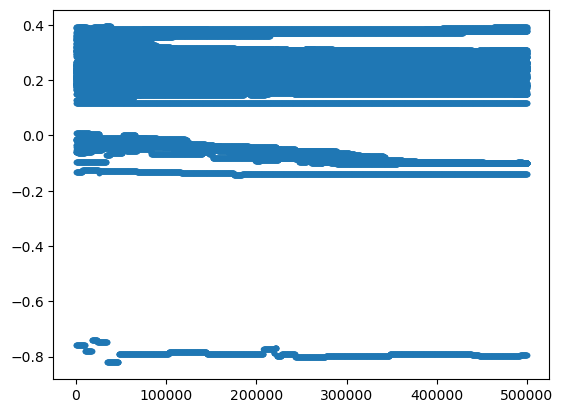

In [730]:
plt.plot(samples_full[:,11],'.')

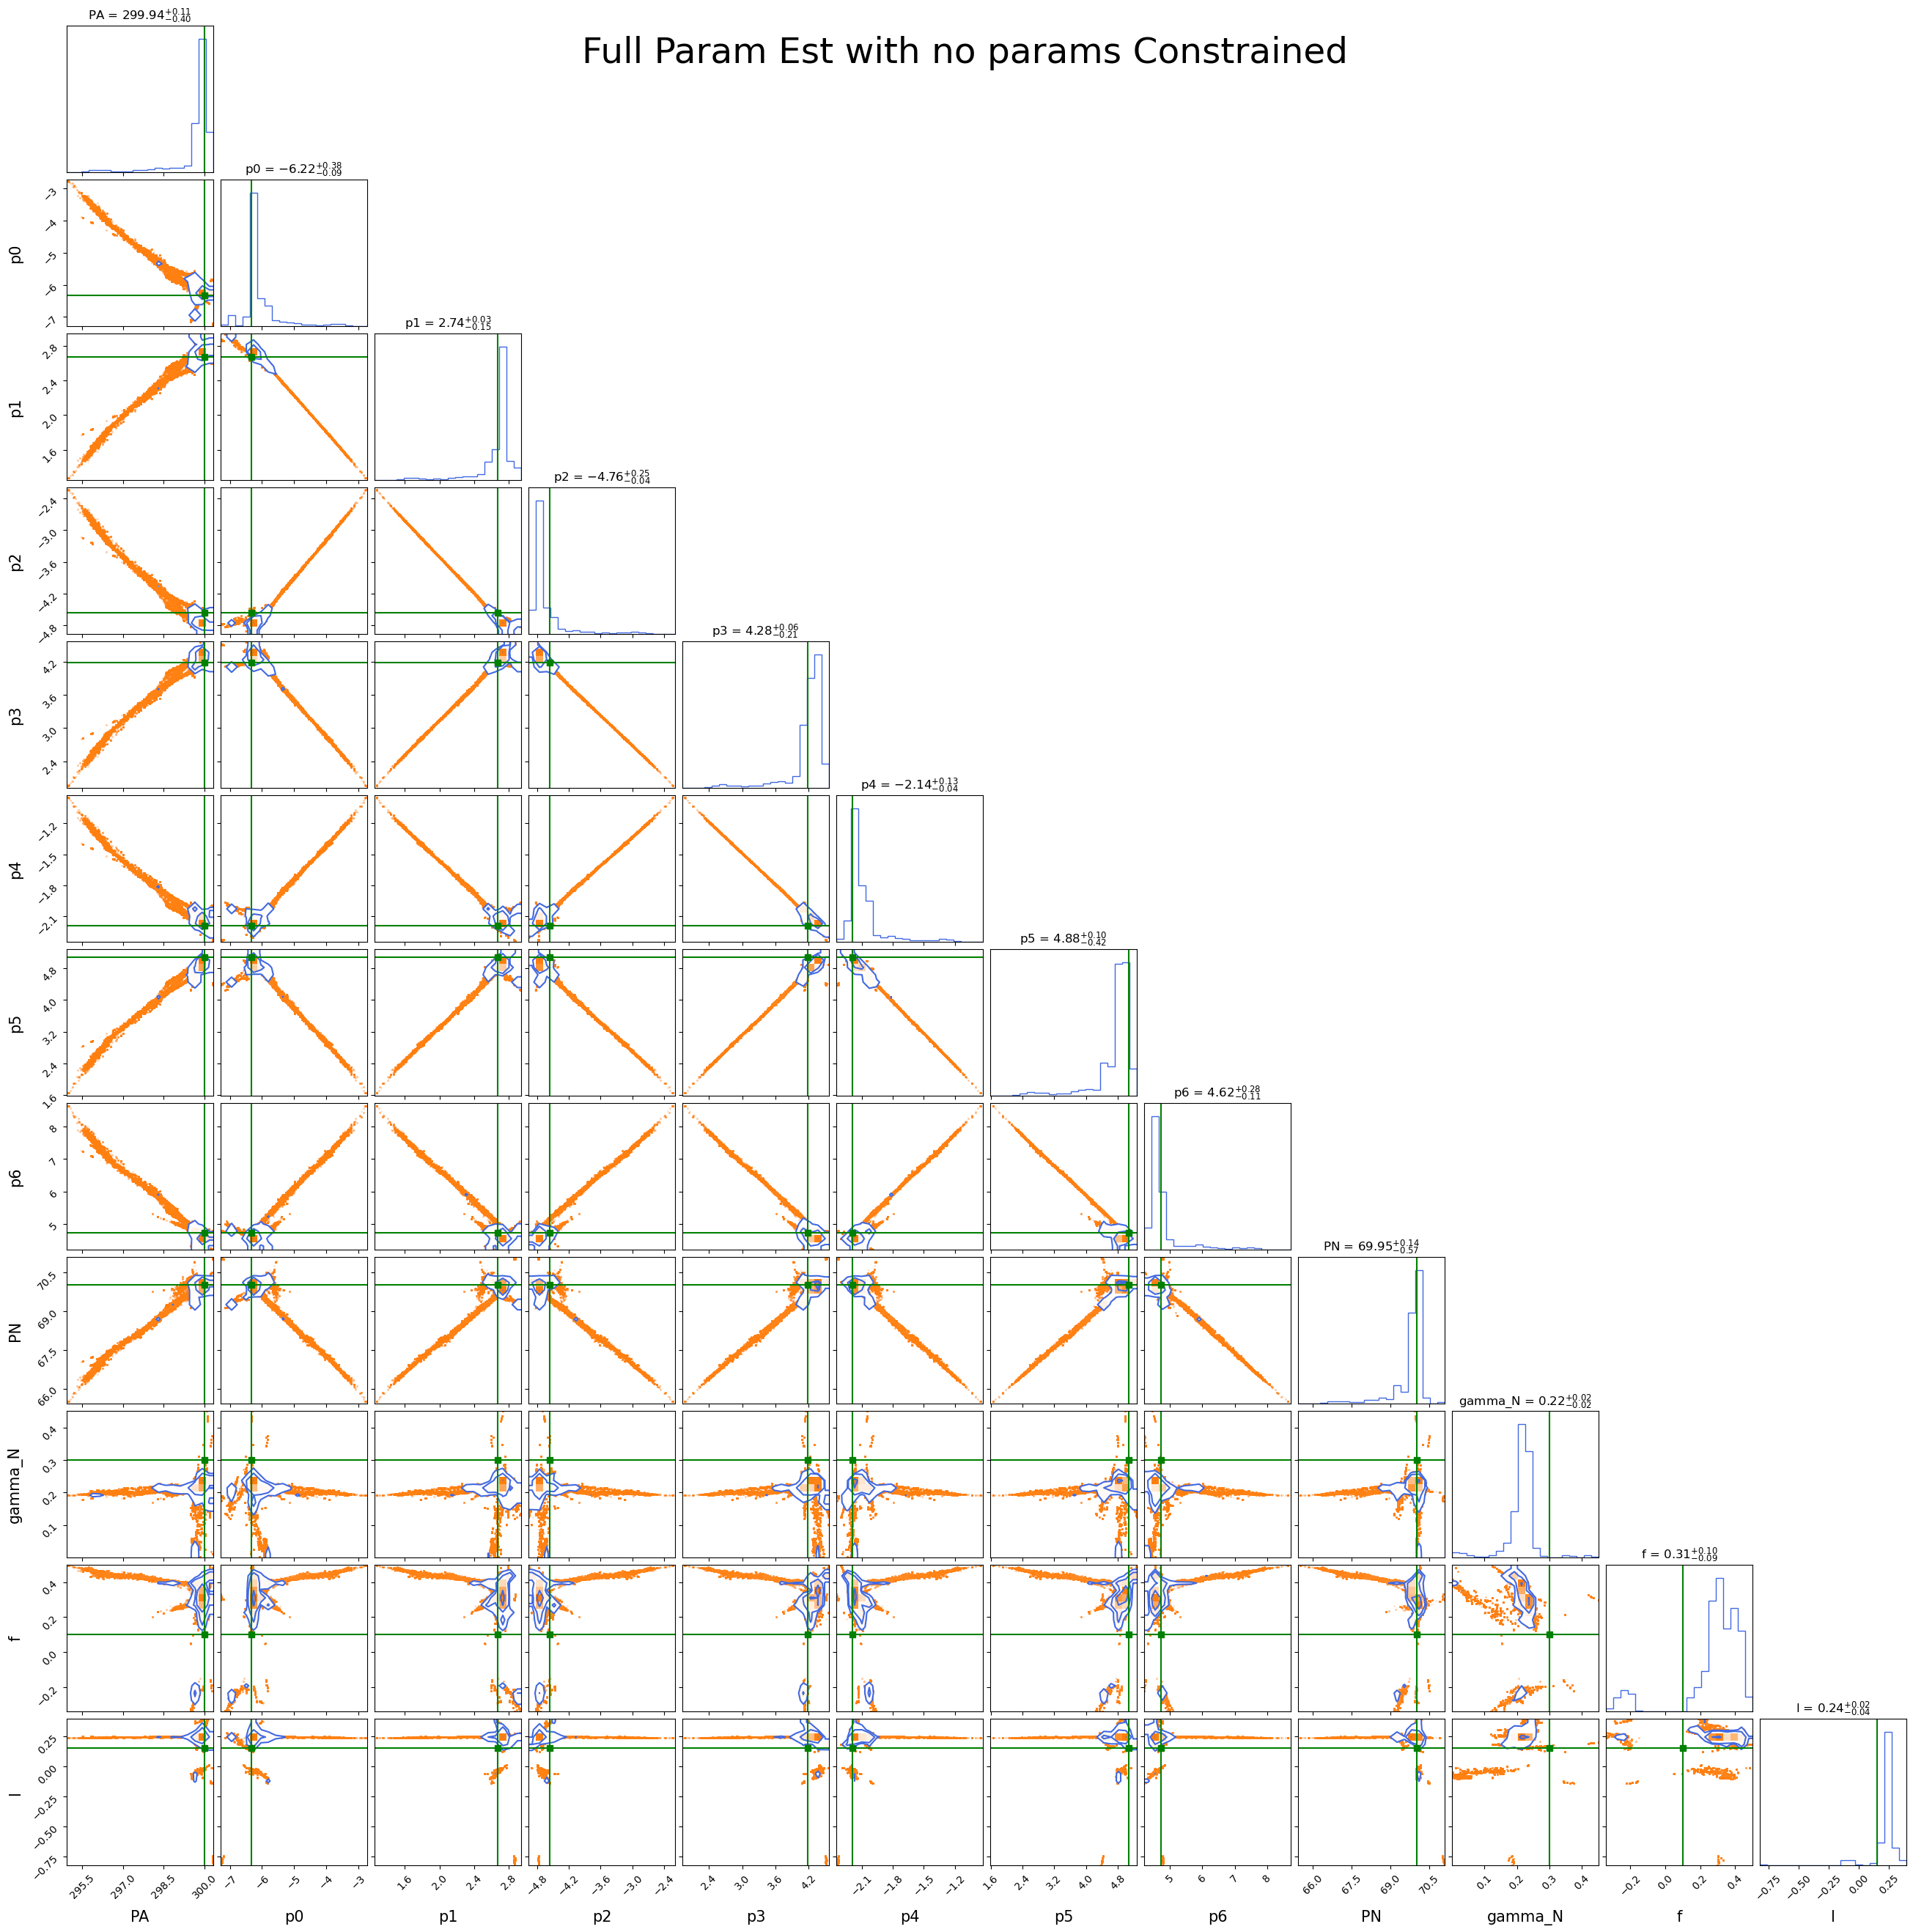

Best-fit parameters (Maximum Likelihood Estimate): [295.12197774907924, -2.8940149901401186, 1.3282692630892572, -2.328678108503111, 2.0538466452414603, -1.0025220633179714, 1.7941908267618483, 8.476879467640643, 65.70006150810212, 0.19238730113993605, 0.49233737186218396, 0.23533027870515896]


In [692]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]
ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
#corner plot 
fig = corner.corner(samples_full, labels=parameter_names, show_titles=True, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Full Param Est with no params Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_Full_gA_1m_.png', dpi=300)
#plt.savefig('Art.png')

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_full)

Text(0, 0.5, 'S11')

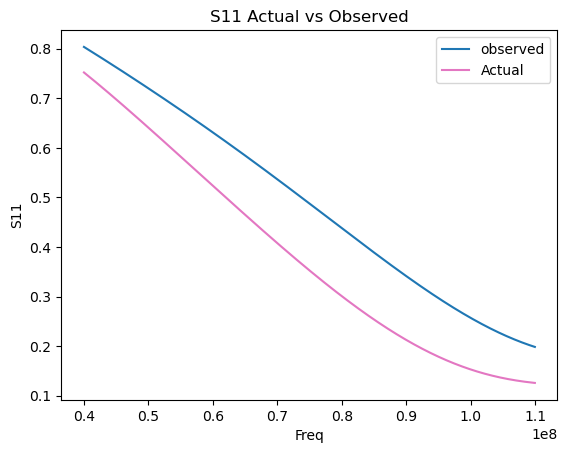

In [693]:
#Reconstructed S11 wrt best fit
v=req_freq
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

yerr=abs(gA_True-gamma_A)
#plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
#plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,gA_True,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

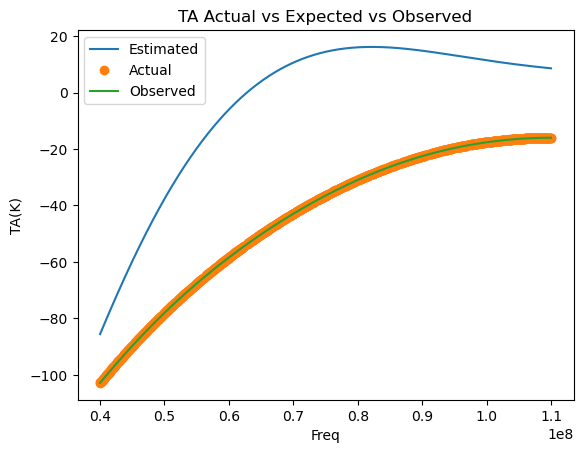

In [696]:
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
TObs=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
#print(TMeas_exp.real[ind_freq].shape())
TMeas=TMeas_exp_avg.real

TEst=Compute_Tmeas_(300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07, 4.73, 70, 0.3, 0.1, 0.15)
plt.plot(req_freq, TEst,label='Estimated')
plt.plot(req_freq,TMeas,'.', label='Actual' )
plt.plot(req_freq,TObs, label='Observed')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA(K)')
plt.title('TA Actual vs Expected vs Observed')
plt.show()

In [697]:
#computing S11 corresponding to all samples
reduced_samples = samples_full
S11_models = np.zeros((len(reduced_samples), len(req_freq)))

for ii in range(len(reduced_samples)):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples[ii]
    S11_models[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

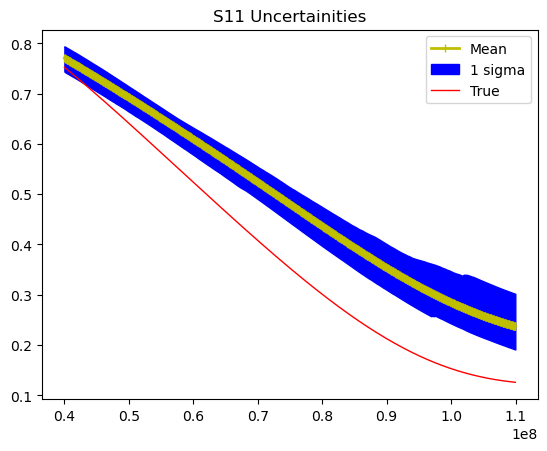

In [698]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
#plt.plot(req_freq, S11_models[0::100].T, alpha=0.1)

S11_mean = np.mean(S11_models, axis=0)
lower_bound, upper_bound = np.percentile(S11_models,[16,84],axis=0)

plt.plot(req_freq, S11_mean, lw=2, color='y', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(req_freq,gA_True, color='r', lw=1.0, label="True")
plt.title("S11 Uncertainities")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Uncertainities Exp vs Obs TA')

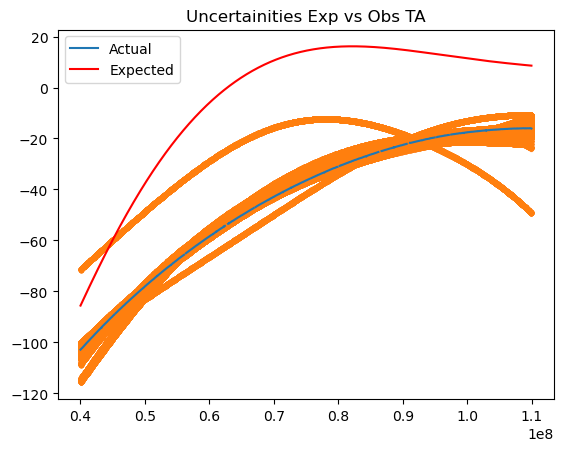

In [700]:
#Recovering Uncertainities in Tmeas
for ii in range(len(reduced_samples[::100])):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples[ii]
    TA_obs=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    plt.plot(req_freq, TA_obs,color='C1', marker=".", alpha=0.2, lw=0.5)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
TMeas=TMeas_exp_avg.real
plt.plot(req_freq,TMeas, label='Actual' )
plt.plot(v,TA_exp, 'r', label="Expected")
plt.legend()
plt.title("Uncertainities Exp vs Obs TA")